In [710]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [711]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [712]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


Load and prepare data


In [713]:
data = pd.read_csv("./data/rnn_full_data.csv")
data

,Year,Month,District,crime_count,Season,sin_month,cos_month
0,2020,1,1.0,1054.0,Winter,0.0,1.000000
1,2020,1,2.0,795.0,Winter,0.0,1.000000
2,2020,1,3.0,1028.0,Winter,0.0,1.000000
3,2020,1,4.0,1074.0,Winter,0.0,1.000000
4,2020,1,5.0,874.0,Winter,0.0,1.000000
...,...,...,...,...,...,...,...
1375,2024,12,20.0,383.0,Winter,-0.5,0.866025
1376,2024,12,22.0,564.0,Winter,-0.5,0.866025
1377,2024,12,24.0,598.0,Winter,-0.5,0.866025
1378,2024,12,25.0,1002.0,Winter,-0.5,0.866025


Create a unique location identifier and time key


In [714]:
data["District"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
       15., 16., 17., 18., 19., 20., 22., 24., 25., 31.])

In [715]:
# combine District 31 with 25
data.loc[data["District"] == 31, "District"] = 25

In [716]:
data["time_key"] = data["Year"] * 12 + data["Month"]
data = (
    data.groupby(["Year", "Month", "sin_month", "cos_month", "time_key", "District"])
    .agg({"crime_count": "sum"})
    .reset_index()
)
data

,Year,Month,sin_month,cos_month,time_key,District,crime_count
0,2020,1,0.0,1.000000,24241,1.0,1054.0
1,2020,1,0.0,1.000000,24241,2.0,795.0
2,2020,1,0.0,1.000000,24241,3.0,1028.0
3,2020,1,0.0,1.000000,24241,4.0,1074.0
4,2020,1,0.0,1.000000,24241,5.0,874.0
...,...,...,...,...,...,...,...
1315,2024,12,-0.5,0.866025,24300,19.0,1057.0
1316,2024,12,-0.5,0.866025,24300,20.0,383.0
1317,2024,12,-0.5,0.866025,24300,22.0,564.0
1318,2024,12,-0.5,0.866025,24300,24.0,598.0


Get unique locations and time points


In [717]:
locations = data["District"].unique()
locations.sort()
n_location = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}
data["district_id"] = data["District"].map(location_map)
data["time_id"] = data["time_key"].map(time_map)
print(location_map)
print(time_map)

{np.float64(1.0): 0, np.float64(2.0): 1, np.float64(3.0): 2, np.float64(4.0): 3, np.float64(5.0): 4, np.float64(6.0): 5, np.float64(7.0): 6, np.float64(8.0): 7, np.float64(9.0): 8, np.float64(10.0): 9, np.float64(11.0): 10, np.float64(12.0): 11, np.float64(14.0): 12, np.float64(15.0): 13, np.float64(16.0): 14, np.float64(17.0): 15, np.float64(18.0): 16, np.float64(19.0): 17, np.float64(20.0): 18, np.float64(22.0): 19, np.float64(24.0): 20, np.float64(25.0): 21}
{np.int64(24241): 0, np.int64(24242): 1, np.int64(24243): 2, np.int64(24244): 3, np.int64(24245): 4, np.int64(24246): 5, np.int64(24247): 6, np.int64(24248): 7, np.int64(24249): 8, np.int64(24250): 9, np.int64(24251): 10, np.int64(24252): 11, np.int64(24253): 12, np.int64(24254): 13, np.int64(24255): 14, np.int64(24256): 15, np.int64(24257): 16, np.int64(24258): 17, np.int64(24259): 18, np.int64(24260): 19, np.int64(24261): 20, np.int64(24262): 21, np.int64(24263): 22, np.int64(24264): 23, np.int64(24265): 24, np.int64(24266): 2

In [718]:
print(f"Number of unique locations: {len(locations)}")
print(f"Number of time points: {len(time_points)}")
data.sort_values("crime_count", ascending=False)

Number of unique locations: 22
Number of time points: 60


,Year,Month,sin_month,cos_month,time_key,District,crime_count,district_id,time_id
1195,2024,7,1.224647e-16,-1.000000e+00,24295,8.0,1634.0,7,54
660,2022,7,1.224647e-16,-1.000000e+00,24271,1.0,1625.0,0,30
1239,2024,9,-8.660254e-01,-5.000000e-01,24297,8.0,1582.0,7,56
946,2023,8,-5.000000e-01,-8.660254e-01,24284,1.0,1551.0,0,43
975,2023,9,-8.660254e-01,-5.000000e-01,24285,8.0,1543.0,7,44
...,...,...,...,...,...,...,...,...,...
568,2022,2,5.000000e-01,8.660254e-01,24266,20.0,281.0,18,25
106,2020,5,8.660254e-01,-5.000000e-01,24245,20.0,276.0,18,4
238,2020,11,-8.660254e-01,5.000000e-01,24251,20.0,275.0,18,10
84,2020,4,1.000000e+00,6.123234e-17,24244,20.0,274.0,18,3


In [719]:
features = ["crime_count", "district_id", "sin_month", "cos_month", "Year"]

In [720]:
n_features = len(features)
matrix = np.zeros((len(time_points), len(locations), n_features))

In [721]:
for _, row in data.iterrows():
    location_id = round(row["district_id"])
    time_id = round(row["time_id"])
    matrix[time_id, location_id] = row[features]
matrix.shape

(60, 22, 5)

In [722]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
matrix_scaled = matrix.copy()
matrix_scaled[:, :, 0] = scaler.fit_transform(matrix[:, :, 0].reshape(-1, 1)).reshape(
    matrix[:, :, 0].shape
)
num_scaler = MinMaxScaler()
matrix_scaled[:, :, 2:] = num_scaler.fit_transform(
    matrix[:, :, 2:].reshape(-1, n_features - 2)
).reshape(matrix[:, :, 2:].shape)

In [723]:
seq_length = 12

In [724]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length, :, 0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

Create sequences


In [725]:
X, y = create_sequences(matrix_scaled, seq_length)
print(X.shape)
print(y.shape)

(48, 12, 22, 5)
(48, 22)


In [726]:
print(f"Number of sequences: {len(X)}")
print(
    f"Input shape: {X.shape}"
)  # [n_sequences, sequence_length, n_locations, n_features]
print(f"Target shape: {y.shape}")  # [n_sequences, n_locations]

Number of sequences: 48
Input shape: (48, 12, 22, 5)
Target shape: (48, 22)


In [727]:
train_size = int(0.75 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [728]:
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")

Training sequences: 36
Validation sequences: 12


Convert to PyTorch tensors


In [729]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

Define the RNN model


In [730]:
input_size = len(features) - 1
hidden_size = 32
batch_size = 16
num_layers = 3
embed_dim = 8
output_size = 1
num_epochs = 50

In [ ]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embed_dim, num_layers, output_size):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.location_embedding = nn.Embedding(len(locations), embed_dim)
        self.lstm = nn.LSTM(
            input_size=input_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [seq_length, batch_size, n_features (crime_count, location_id)]

        batch_size = x.size(1)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # location_embed: [seq_length, batch_size, embed_dim]
        location_embed = self.location_embedding(x[:, :, 1].long())
        # crime: [seq_length, batch_size, 1]
        crime = x[:, :, 0].unsqueeze(-1)
        num = x[:, :, 2:]
        # Combine crime and location embeddings
        x = torch.cat((crime, location_embed, num), dim=-1)
        # x: [seq_length, batch_size, embed_dim + 1]
        output, (_, _) = self.lstm(x, (h_0, c_0))
        output = self.fc1(output[-1])
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [732]:
print(X_train.shape)
model = CrimeLSTM(input_size, hidden_size, embed_dim, num_layers, output_size).to(
    device
)
print(model)

(36, 12, 22, 5)
CrimeLSTM(
  (location_embedding): Embedding(22, 8)
  (lstm): LSTM(12, 32, num_layers=3)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Define loss function and optimizer


In [733]:
criterion = nn.MSELoss()

Training function


In [734]:
# Validation
def evaluate_model(model, X_val_tensor, y_val_tensor):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for i in range(len(X_val)):
            for batch in range(0, n_location, batch_size):
                sequence = X_train_tensor[i, :, batch : batch + batch_size]
                target = y_train_tensor[i, batch : batch + batch_size]
                score = model(sequence)
                loss = criterion(score, target.unsqueeze(1))
                val_loss += loss.item()
                num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [735]:
start_time = time.time()
n_location = len(locations)
train_losses = []
val_losses = []
my_lr = 0.001
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    my_lr = my_lr / 1.1
    optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
    for i in range(len(X_train)):
        for batch in range(0, n_location, batch_size):
            optimizer.zero_grad()
            sequence = X_train_tensor[i, :, batch : batch + batch_size]
            target = y_train_tensor[i, batch : batch + batch_size]
            score = model(sequence)
            loss = criterion(score, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, X_val_tensor, y_val_tensor)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, learning rate: {my_lr:.12f}, time: {time.time() - start_time:.2f} seconds"
    )

Epoch [1/50], Train Loss: 0.038673955287, Val Loss: 0.069632689236, learning rate: 0.000909090909, time: 1.47 seconds
Epoch [2/50], Train Loss: 0.026648918733, Val Loss: 0.047901197880, learning rate: 0.000826446281, time: 2.31 seconds
Epoch [3/50], Train Loss: 0.020283249471, Val Loss: 0.043275336502, learning rate: 0.000751314801, time: 3.09 seconds
Epoch [4/50], Train Loss: 0.016386069509, Val Loss: 0.040279418502, learning rate: 0.000683013455, time: 3.87 seconds
Epoch [5/50], Train Loss: 0.016818217583, Val Loss: 0.043092023775, learning rate: 0.000620921323, time: 4.61 seconds
Epoch [6/50], Train Loss: 0.016325281074, Val Loss: 0.036476598587, learning rate: 0.000564473930, time: 5.47 seconds
Epoch [7/50], Train Loss: 0.015646563066, Val Loss: 0.035174773734, learning rate: 0.000513158118, time: 6.27 seconds
Epoch [8/50], Train Loss: 0.014711407838, Val Loss: 0.029842960260, learning rate: 0.000466507380, time: 6.95 seconds
Epoch [9/50], Train Loss: 0.012827740111, Val Loss: 0.02

Train the model


Plot training and validation loss


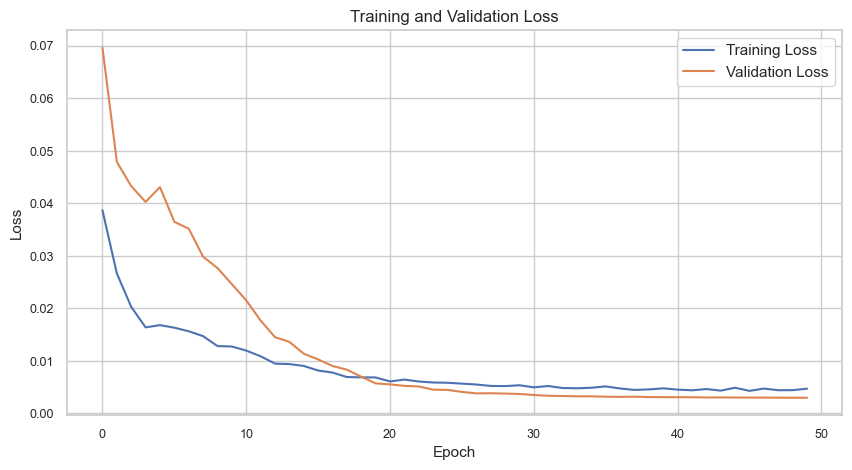

In [736]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.pdf")
plt.show()

In [737]:
def predictions(model, X, y):
    num_seq, _, n_location, n_features = X.shape
    result = np.zeros((num_seq, n_location, 2))
    with torch.no_grad():
        for i in range(len(X)):
            for batch in range(0, n_location, batch_size):
                batch_increment = min(batch_size, n_location - batch)
                sequence = X[i, :, batch : batch + batch_increment]
                target = y[i, batch : batch + batch_increment]
                score = model(sequence)
                result[i, batch : batch + batch_increment, 0] = (
                    score.cpu().numpy().flatten()
                )
                result[i, batch : batch + batch_increment, 1] = (
                    target.cpu().numpy().flatten()
                )
    return result

In [738]:
prediction_model = model.to("mps")
result = predictions(model, X_val_tensor.to("mps"), y_val_tensor.to("mps"))
unscaled_result = scaler.inverse_transform(result.reshape(-1, 2)).reshape(result.shape)

In [739]:
unscaled_result

array([[[1095.24757051, 1075.0000124 ],
        [1090.34347963,  988.00001812],
        [1140.89359665, 1039.99998283],
        [1248.76565742, 1065.99996519],
        [ 876.17379761,  811.99999642],
        [1307.78671408, 1138.00001669],
        [ 926.3308959 ,  789.99999881],
        [1354.99698734, 1246.0000124 ],
        [ 948.94080639,  852.00000691],
        [ 892.00910902,  841.00000811],
        [1214.67584944, 1074.00001621],
        [1258.78592253, 1137.0000205 ],
        [ 728.03370714,  736.99999714],
        [ 745.89273882,  620.99999118],
        [ 843.08194733,  714.00000334],
        [ 660.60661602,  568.00000989],
        [1160.65950298, 1043.99996758],
        [1117.90705681,  918.99999595],
        [ 458.65900087,  448.99999499],
        [ 690.69537926,  570.99999845],
        [ 758.10746717,  806.00001931],
        [1102.60191298, 1030.00002098]],

       [[1083.28797817, 1094.00002146],
        [1081.00993729,  987.00002193],
        [1128.74002266, 1037.99999046]

Overall Metrics Summary:
                    MAE    MAPE(%)        RMSE         R²
District_1    81.393824   6.526989   98.229195   0.414853
District_2   108.360270  10.356224  122.079048  -0.351408
District_3   179.623068  17.032208  204.945988  -5.036507
District_4   204.165779  18.160877  209.962366  -9.281229
District_5    98.284490  12.343820  117.352303  -1.084944
District_6   157.561797  13.547886  184.597952  -1.861960
District_7   112.013618  13.158719  123.948742  -1.176823
District_8    89.330784   6.351936  106.322834   0.271018
District_9   124.895058  13.557644  136.922738  -2.038373
District_10  108.152090  12.669522  122.161648  -3.210821
District_11  174.832381  15.961733  191.055022  -3.203032
District_12   80.839670   6.164404   90.677697   0.491158
District_13   67.595344   7.907940   80.458444   0.254434
District_14   88.862552  12.633536  100.969867  -1.824276
District_15  220.909087  30.053274  235.801393 -16.761156
District_16   93.016809  14.368529  108.977912 

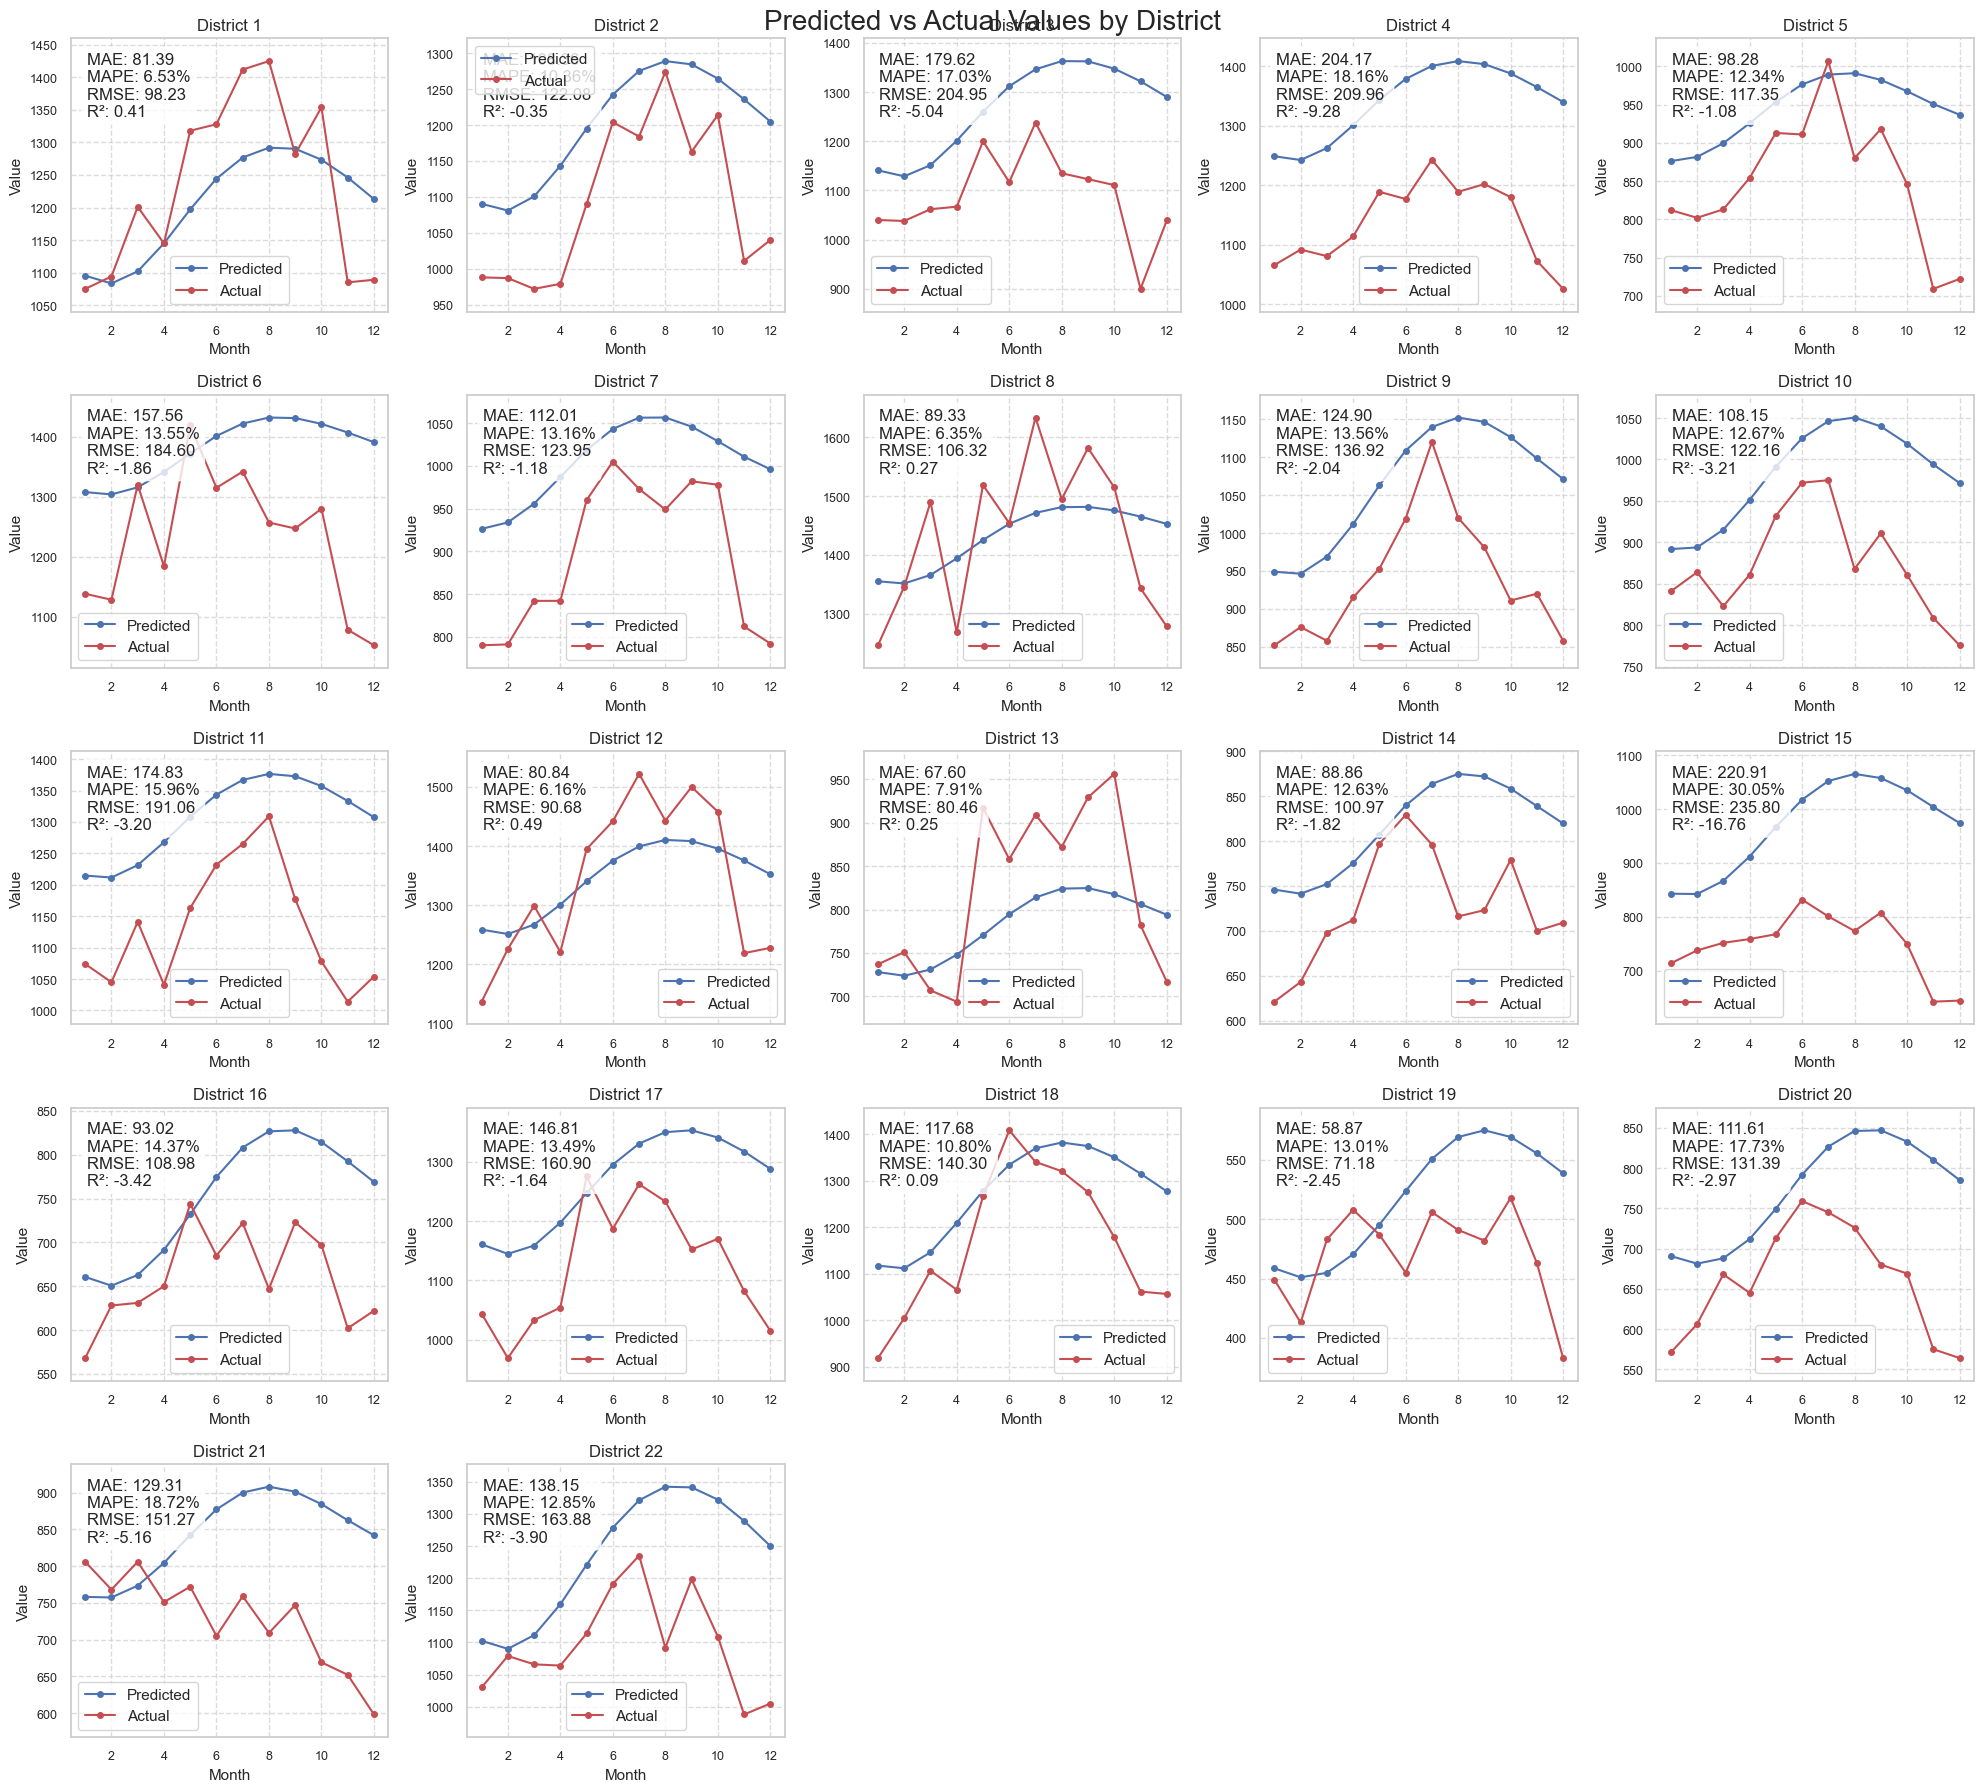

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def plot_district_predictions(data, save_path=None):
    """
    Plot predicted vs actual values for each district over time and calculate error metrics.

    Parameters:
    -----------
    data : numpy.ndarray
        3D array of shape (months, districts, 2) where the last dimension
        contains [predicted, actual] values.
    save_path : str, optional
        If provided, the figure will be saved to this path.

    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plots.
    dict
        Dictionary containing error metrics for each district.
    """
    num_months, num_districts, _ = data.shape

    # Determine grid size for subplots (5x5 grid to fit 23 districts)
    cols = 5
    rows = 5

    # Create figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 18))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Create x-axis data (months)
    months = np.arange(1, num_months + 1)

    # Dictionary to store metrics for each district
    metrics = {}

    # Plot each district
    for i in range(num_districts):
        ax = axes[i]

        # Extract predicted and actual values for this district
        predicted = data[:, i, 0]
        actual = data[:, i, 1]

        # Calculate metrics for non-NaN values
        valid_indices = ~np.isnan(predicted) & ~np.isnan(actual)
        valid_predicted = predicted[valid_indices]
        valid_actual = actual[valid_indices]

        if len(valid_actual) > 0:
            # Calculate Mean Absolute Error
            mae = mean_absolute_error(valid_actual, valid_predicted)

            # Calculate MAE percentage (MAPE)
            # Avoid division by zero by adding a small epsilon
            epsilon = 1e-10
            mape = (
                np.mean(
                    np.abs((valid_actual - valid_predicted) / (valid_actual + epsilon))
                )
                * 100
            )

            # Calculate Root Mean Squared Error
            rmse = np.sqrt(mean_squared_error(valid_actual, valid_predicted))

            # Calculate R-squared (coefficient of determination)
            r2 = r2_score(valid_actual, valid_predicted)

            # Store metrics
            metrics[f"District_{i+1}"] = {
                "MAE": mae,
                "MAPE(%)": mape,
                "RMSE": rmse,
                "R²": r2,
            }

            # Add metrics to the plot
            metrics_text = (
                f"MAE: {mae:.2f}\nMAPE: {mape:.2f}%\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"
            )
            ax.text(
                0.05,
                0.95,
                metrics_text,
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

        # Plot the data
        ax.plot(months, predicted, "b-o", label="Predicted", markersize=4)
        ax.plot(months, actual, "r-o", label="Actual", markersize=4)

        # Add title and labels
        ax.set_title(f"District {i+1}")
        ax.set_xlabel("Month")
        ax.set_ylabel("Value")

        # Add grid
        ax.grid(True, linestyle="--", alpha=0.7)

        # Add legend to each subplot
        ax.legend(loc="best")

        # Set y limits with a bit of padding
        all_values = np.concatenate([predicted, actual])

        # Filter out NaN values for computing limits
        valid_values = all_values[~np.isnan(all_values)]
        if len(valid_values) > 0:
            min_val = np.min(valid_values)
            max_val = np.max(valid_values)
            padding = 0.1 * (max_val - min_val)
            ax.set_ylim(min_val - padding, max_val + padding)

    # Hide any unused subplots
    for i in range(num_districts, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    # Add a title for the whole figure
    fig.suptitle("Predicted vs Actual Values by District", fontsize=20, y=0.995)

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    # Create a summary of metrics across all districts
    district_metrics_df = None
    try:
        import pandas as pd

        district_metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
        print("Overall Metrics Summary:")
        print(district_metrics_df)
        print("\nAverage Metrics Across All Districts:")
        print(district_metrics_df.mean())
    except ImportError:
        print("Pandas not available for summary table, printing raw metrics instead:")
        for district, metric in metrics.items():
            print(f"{district}: {metric}")

    return fig, metrics


# Example usage with your data
# Assuming your data is already loaded into a variable called 'unscaled_result'
fig, metrics = plot_district_predictions(unscaled_result)
plt.show()

In [741]:
rounded_result = np.round(unscaled_result)
month_result = np.sum(rounded_result, axis=1)
month_result

array([[21623., 19518.],
       [21503., 19889.],
       [21882., 20853.],
       [22649., 20394.],
       [23578., 22905.],
       [24434., 23086.],
       [25027., 23991.],
       [25292., 22825.],
       [25222., 22786.],
       [24893., 22282.],
       [24396., 19522.],
       [23866., 19269.]])

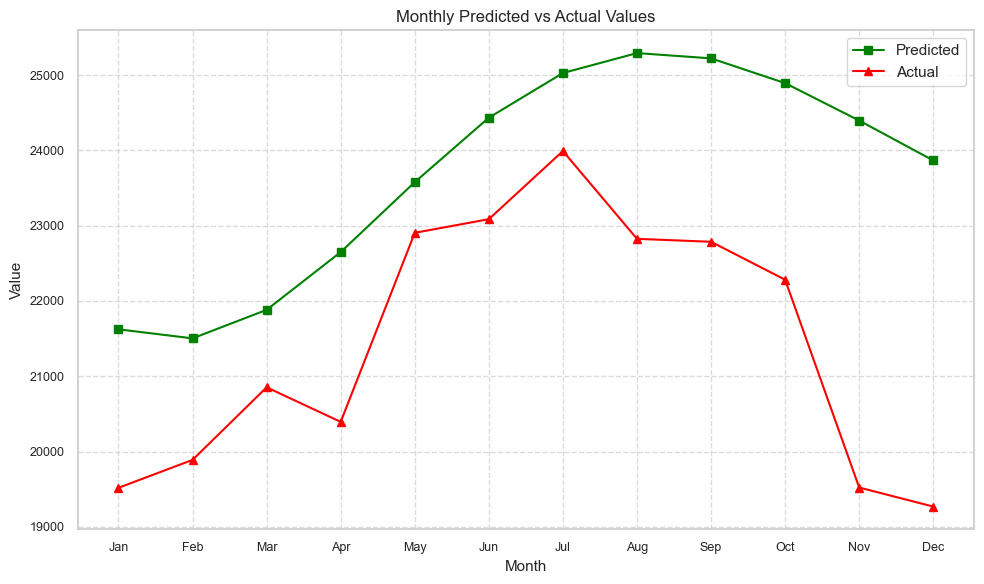

In [742]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming month_result is already calculated as shown in your code
# month_result = np.sum(rounded_result, axis=1)

# Create a list of month labels
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Plot the month_result
plt.figure(figsize=(10, 6))
plt.plot(
    months,
    month_result[:, 0],
    marker="s",
    linestyle="-",
    color="green",
    label="Predicted",
)
plt.plot(
    months, month_result[:, 1], marker="^", linestyle="-", color="red", label="Actual"
)

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Monthly Predicted vs Actual Values")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()